this script calculate the profile change of countries without publications that are funded by specific country
- raw_path: the number of publication in discipline of countries
- filter_path: same with above but without pubs that funded by specific country
- flag_path: file contains country name and iso-3 code

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
import funding.core
import itertools
from scipy.special import rel_entr

## Input

In [2]:
cntry_full_path="../../data/nf_folder/Data/DerivedData/Derived/cntry_author_full.csv"
cntry_filter_path="../../data/nf_folder/Data/DerivedData/Derived/dep-FundExchange/pub_no_foreign_top20.csv"
flag_path='../../data/nf_folder/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv'

plot_path='../../data/nf_folder/Figs/dep-FundExchange/pub_profilechange_bytop10.pdf'

In [3]:
# Parameters
cntry_full_path = (
    "../data/NationalFunding/Data/DerivedData/Derived/cntry_author_full.csv"
)
cntry_filter_path = "../data/NationalFunding/Data/DerivedData/Derived/dependence/pub_noforeign_exclusive_fund_top20.csv"
flag_path = "../data/NationalFunding/Data/AdditionalData/country_WoS_ECI_WB_flags.tsv"
plot_path = "../data/NationalFunding/Figs/Figs/profilechange_exclusive_by_top10.pdf"


## read file

In [4]:
raw_df=pd.read_csv(cntry_full_path)
filter_df=pd.read_csv(cntry_filter_path)
filter_df=filter_df.rename(columns={'author_distinct':'cntry'})
flag_df=pd.read_csv(flag_path,sep='\t')[['WoS','Code']]

## calculate the profile change caused by country **c** in year **y**

In [5]:
srce=filter_df.srce_cntry.unique()
year=filter_df.year.unique()
result=[]
for y in year:
    raw_year=raw_df[raw_df.year==y]
    raw_year=funding.core.group_wide(raw_year)
    filter_year=filter_df[filter_df.year==y]
    for c in srce:
        filter_year_c=filter_year[filter_year.srce_cntry==c]
        filter_year_c=funding.core.group_wide(filter_year_c)
        for index, row in filter_year_c.iterrows():
            cntry=index
            p=row.values
            q=raw_year.loc[cntry,:].values
            kl_value=sum(rel_entr(p,q))
            result.append([cntry,kl_value,c,y])
result_df=pd.DataFrame(result,columns=['cntry','kl','srce_cntry','year'])

## remove the data of the country itself

In [6]:
result_df=result_df[result_df.cntry!=result_df.srce_cntry]

/home/miaoli/funding/national-funding/libs/funding/funding/core.py:75: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x=xcol,y=ycol,err_style='bars',ci=95,hue='Code',data=df,ax=ax,legend=False,palette=palette)


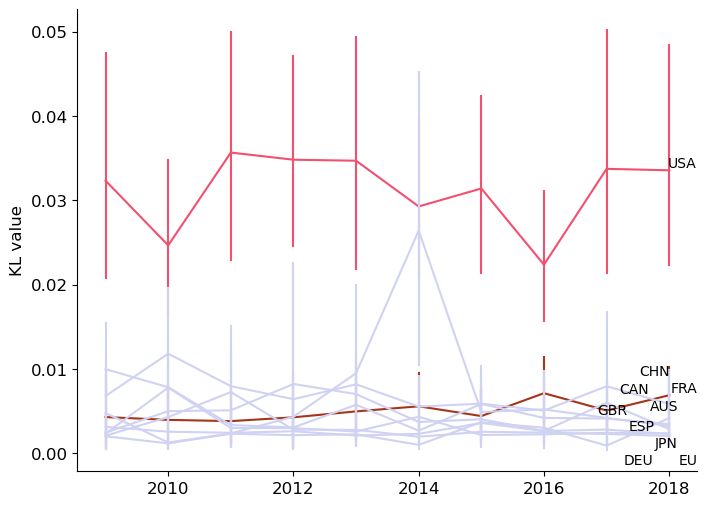

In [7]:
result_df=result_df.merge(flag_df,left_on='srce_cntry',right_on='WoS',how='left')

fig, ax=plt.subplots(figsize=(8,6))
topnlist,yvalues=funding.core.select_topn(result_df,'Code','kl',2018,10)
ax=funding.core.plot(result_df,'year','kl',ax,topnlist,yvalues,'KL value')
plt.savefig(plot_path, bbox_inches='tight')